# Image model training
## Imports

In [1]:
from tensorflow.keras.callbacks import LearningRateScheduler
from joblib import dump
from IPython.display import clear_output

from image_model_training import *

## Parámetros
Se establecen los parámetros para el entrenamiento.

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
label_index_dir = f"{saved_models_dir}/label index mappings"

data_origin = MICRO
clear_training_prints = True

if data_origin == MICRO:
    data_dir = f"{project_dir}/samples/microcontroller/preprocessed image/train"
    augment = True
    origin_name = "Micro"
    epochs = 2000

else:
    data_dir = f"{project_dir}/samples/external/preprocessed image/train"
    augment = False
    origin_name = "Ext"
    epochs = 50 # Por limitaciones de RAM no se pueden entrenar demasiados epochs.

input_shape = (*IMG_SIZE, 1)

model_name = f"{origin_name}{DATA_TYPE}DataModel"

log_dir = f"{saved_models_dir}/summaries/{model_name}"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"

validation_percentage = 20.

initial_learning_rate = 0.001
decay = (initial_learning_rate / epochs) * 1.5

## Carga de datos
Se generan datasets de entrenamiento, validación y test a partir de las imágenes recolectadas.

In [3]:
train_dataset, validation_dataset = get_image_datasets(data_dir, validation_percentage)
class_names = train_dataset.class_names

Found 275 files belonging to 3 classes.
Using 220 files for training.
Found 275 files belonging to 3 classes.
Using 55 files for validation.


Aplicamos o no data augmentation que consiste en aplicar pequeñas rotaciones, zoom o hacer flips horizontales de la
imagen.

In [4]:
if augment:
    train_dataset = augment_data(train_dataset, input_shape)
    validation_dataset = augment_data(validation_dataset, input_shape)

Comprobamos el contenido de los datasets. Primero listamos las classes y luego mostramos una pequeña muestra del
conjunto training.

Aprovechamos para guardar la correspondencia entre las labels del dataset y su nombre.

Classes:
	0: face
	1: mask
	2: nothing


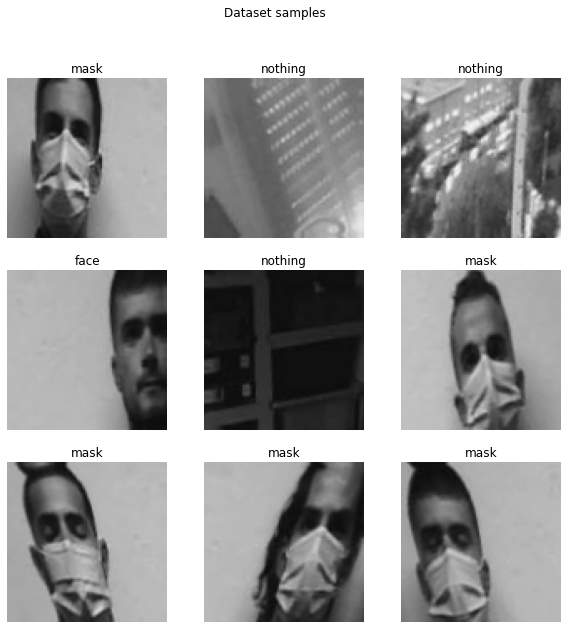

In [5]:
class_list_text = "Classes:"
for index, name in enumerate(class_names):
    class_list_text += f"\n\t{index}: {name}"
    
print(class_list_text)
with open(f"{label_index_dir}/{model_name}.txt", "wt") as text_file:
    text_file.write(class_list_text)

dump(class_names, f"{label_index_dir}/{model_name}.joblib")

demo_image_dataset(train_dataset, class_names=class_names)

Ajustamos la configuración de los datasets para entrenamiento para evitar cuellos de botella en su lectura.

In [6]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Normalizamos el dataset para que los datos tengan valores en [-1, 1] que funcionan mejor para entrenar el modelo.py

Esta operación ahora se realiza en el inicio del modelo.

In [7]:
# train_dataset = normalize_dataset(train_dataset)
# validation_dataset = normalize_dataset(validation_dataset)

## Creación del modelo

Se crea el modelo que se entrenará. Visualizamos la estructura del modelo creado, donde se ve también el número de
parámetros.

In [8]:
model = get_image_model(input_shape, len(class_names), model_name)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "MicroImgDataModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 47, 4)         40        
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 4)         16        
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 47, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 8)         296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 8)         32        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 47, 47, 8)   

## Entrenamiento del modelo

Se entrena el modelo creado con los datos de entrenamiento y validación.

In [9]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

def lr_time_based_decay(epoch: int, lr: float) -> float:
    """
    Callback function que reduce el learning rate conforme avanza el entrenamiento.
    Args:
        epoch:  int que representa el epoch del entrenamiento que se va a realizar a continuación.
        lr:     float con el learning rate del último epoch.

    Returns:
        float con el nuevo learning rate
    """
    return lr * 1 / (1 + decay * epoch)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[tensorboard_callback, LearningRateScheduler(lr_time_based_decay, verbose=1)]
)

if clear_training_prints:
    clear_output()
    print("Entrenamiento finalizado.")

Entrenamiento finalizado.


El output de la celda anterior se ha eliminado porque era demasiado grande y causaba problemas para visualizarla en
GitHub.
## Visualización de historial de entrenamiento

Se visualiza accuracy y loss de training y validation.

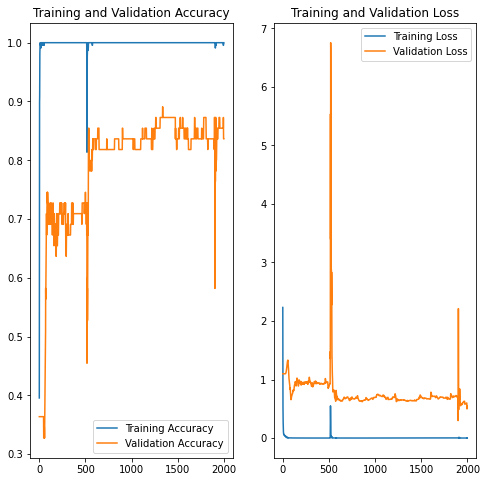

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.savefig(f"{log_dir}/training_data.jpg")

plt.show()

## Guardar modelo
Guardamos el modelo entrenado para poder reutilizarlo en el futuro.

In [11]:
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/MicroImgDataModel/assets
